1. Замена всех классов в датасетах на 1 (сорняк)

In [1]:
import os

def relabel_all_txt_files(label_dir, new_class=1):
    """
    Заменяет метки в YOLO-файлах на new_class (по умолчанию 1 — 'weed')
    """
    for root, _, files in os.walk(label_dir):
        for file in files:
            if file.endswith('.txt'):
                file_path = os.path.join(root, file)
                new_lines = []
                with open(file_path, 'r') as f:
                    for line in f:
                        parts = line.strip().split()
                        if len(parts) >= 5:
                            parts[0] = str(new_class)  # заменяем класс
                            new_lines.append(' '.join(parts) + '\n')
                with open(file_path, 'w') as f:
                    f.writelines(new_lines)

# Путь к каталогу с датасетами
base_path = "Dataset"

# 1. Обработка Weed25
weed25_label_paths = [
    os.path.join(base_path, "Weed25", "train", "labels"),
    os.path.join(base_path, "Weed25", "valid", "labels")
]

for path in weed25_label_paths:
    relabel_all_txt_files(path, new_class=1)

# 2. Обработка Roboflow
roboflow_label_paths = [
    os.path.join(base_path, "Roboflow", "train", "labels"),
    os.path.join(base_path, "Roboflow", "valid", "labels"),
    os.path.join(base_path, "Roboflow", "test", "labels")
]

for path in roboflow_label_paths:
    relabel_all_txt_files(path, new_class=1)

print("✅ Разметка обновлена: все классы в Weed25 и Roboflow теперь — класс 1 (weed).")


✅ Разметка обновлена: все классы в Weed25 и Roboflow теперь — класс 1 (weed).


2. Объединение датасетов и деление данных

In [2]:
import os
import shutil
import random
from pathlib import Path

# Путь к папке Dataset внутри AgroVisionV2
base_path = Path("Dataset")
output_path = Path("AgroVisionDataset")

# Папки, где хранятся датасеты
dataset_sources = {
    "CropWeed": base_path / "Crop and Weed Detection" / "agri_data" / "data",
    "Weed25_train": base_path / "Weed25" / "train",
    "Weed25_valid": base_path / "Weed25" / "valid",
    "Roboflow_train": base_path / "Roboflow" / "train",
    "Roboflow_valid": base_path / "Roboflow" / "valid",
    "Roboflow_test": base_path / "Roboflow" / "test"
}

# Временная папка для объединения всех данных
raw_images = output_path / "raw" / "images"
raw_labels = output_path / "raw" / "labels"
raw_images.mkdir(parents=True, exist_ok=True)
raw_labels.mkdir(parents=True, exist_ok=True)

# Копируем все изображения и метки в одну папку
print("📦 Сбор изображений и аннотаций...")
counter = 0
for name, path in dataset_sources.items():
    img_dir = path / "images" if (path / "images").exists() else path
    lbl_dir = path / "labels" if (path / "labels").exists() else path

    for file in img_dir.iterdir():
        if file.suffix.lower() in [".jpg", ".jpeg", ".png"]:
            label_file = lbl_dir / (file.stem + ".txt")
            if label_file.exists():
                new_name = f"{name}_{counter}{file.suffix.lower()}"
                new_label = f"{name}_{counter}.txt"

                shutil.copy(file, raw_images / new_name)
                shutil.copy(label_file, raw_labels / new_label)
                counter += 1

print(f"✅ Всего собрано: {counter} изображений + аннотаций")

# --- Делим на train/val/test ---
print("🔀 Разделение на train / val / test...")
all_files = list(raw_images.glob("*"))
random.shuffle(all_files)

train_split = int(0.8 * len(all_files))
val_split = int(0.9 * len(all_files))

splits = {
    "train": all_files[:train_split],
    "val": all_files[train_split:val_split],
    "test": all_files[val_split:]
}

for split, files in splits.items():
    for file in files:
        img_dst = output_path / "images" / split
        lbl_dst = output_path / "labels" / split
        img_dst.mkdir(parents=True, exist_ok=True)
        lbl_dst.mkdir(parents=True, exist_ok=True)

        shutil.copy(file, img_dst / file.name)
        shutil.copy(raw_labels / (file.stem + ".txt"), lbl_dst / (file.stem + ".txt"))

print("✅ Разделение завершено.")


📦 Сбор изображений и аннотаций...
✅ Всего собрано: 15503 изображений + аннотаций
🔀 Разделение на train / val / test...
✅ Разделение завершено.


3. Создаем data.yaml

In [4]:
import yaml
from pathlib import Path

# Путь к финальному датасету
dataset_root = Path("AgroVisionDataset")

# Полные абсолютные пути (Windows-совместимо)
train_path = str((dataset_root / "images" / "train").resolve())
val_path   = str((dataset_root / "images" / "val").resolve())
test_path  = str((dataset_root / "images" / "test").resolve())

# YAML-структура
data = {
    "names": ["crop", "weed"],
    "nc": 2,
    "train": train_path.replace("\\", "/"),
    "val": val_path.replace("\\", "/"),
    "test": test_path.replace("\\", "/")
}

# Сохраняем в YAML-файл
yaml_path = dataset_root / "data.yaml"
with open(yaml_path, 'w') as f:
    yaml.dump(data, f, default_flow_style=False)

print(f"✅ Файл data.yaml успешно создан по пути:\n{yaml_path.resolve()}")


✅ Файл data.yaml успешно создан по пути:
E:\progs\AgroVisionV2\AgroVisionDataset\data.yaml


5. Запускаем обучение

In [1]:
from ultralytics import YOLO

# Загружаем модель YOLOv11m
model = YOLO("yolo11m.pt")

# Запускаем обучение
model.train(
    data="AgroVisionDataset/data.yaml",  # путь к вашему data.yaml
    epochs=50,                           # количество эпох
    imgsz=640,                           # размер входных изображений
    batch=16,                            # рекомендовано для RTX 3070
    name="agro_final_v11m",             # имя эксперимента (папка в runs/detect/)
    patience=10                          # early stopping — если 10 эпох без улучшений
)



New https://pypi.org/project/ultralytics/8.3.103 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.102  Python-3.12.2 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolo11m.pt, data=AgroVisionDataset/data.yaml, epochs=50, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=agro_final_v11m2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, 

train: Scanning E:\progs\AgroVisionV2\AgroVisionDataset\labels\train.cache... 12402 images, 1 backgrounds, 0 corrupt: 1
val: Scanning E:\progs\AgroVisionV2\AgroVisionDataset\labels\val.cache... 1550 images, 0 backgrounds, 0 corrupt: 100%|█


Plotting labels to runs\detect\agro_final_v11m2\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\agro_final_v11m2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      7.97G      1.721      1.879      1.941          7        640: 100%|██████████| 776/776 [13:10<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [01:14

                   all       1550       2596      0.253      0.432      0.309       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      7.99G      1.701      1.727      1.917          7        640: 100%|██████████| 776/776 [13:05<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [01:32

                   all       1550       2596       0.77        0.5      0.675      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      8.06G      1.643      1.579      1.851          9        640: 100%|██████████| 776/776 [09:44<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [01:15

                   all       1550       2596      0.651      0.604      0.675      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      8.06G      1.586       1.45      1.794          7        640: 100%|██████████| 776/776 [17:12<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [01:40

                   all       1550       2596      0.668      0.608      0.684      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      8.04G       1.53      1.366      1.752          8        640: 100%|██████████| 776/776 [18:12<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [01:39

                   all       1550       2596      0.661      0.688      0.697      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      8.06G      1.499      1.321      1.721          5        640: 100%|██████████| 776/776 [13:58<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [01:32

                   all       1550       2596      0.735      0.691      0.771      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      8.05G       1.46      1.248      1.692          7        640: 100%|██████████| 776/776 [12:50<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [01:18

                   all       1550       2596      0.651      0.736      0.783      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      8.07G      1.439      1.212       1.68          2        640: 100%|██████████| 776/776 [20:12<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [01:41

                   all       1550       2596      0.765       0.74      0.797       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      8.05G      1.425      1.175      1.667          3        640: 100%|██████████| 776/776 [11:57<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [01:18

                   all       1550       2596      0.806      0.728      0.831       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      8.06G      1.417      1.149      1.651          3        640: 100%|██████████| 776/776 [09:46<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [01:10

                   all       1550       2596      0.816       0.76      0.851       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      8.05G      1.397      1.127      1.641          3        640: 100%|██████████| 776/776 [17:30<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [01:30

                   all       1550       2596      0.835      0.689      0.833        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      8.08G      1.386      1.095      1.628          5        640: 100%|██████████| 776/776 [09:55<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [01:32

                   all       1550       2596      0.794      0.749      0.826      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      8.05G      1.374       1.08      1.616          6        640: 100%|██████████| 776/776 [16:57<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [01:34

                   all       1550       2596      0.796      0.772      0.848      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      8.05G       1.36      1.066      1.605          3        640: 100%|██████████| 776/776 [11:15<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [01:28

                   all       1550       2596       0.82      0.766      0.852      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      8.06G      1.359      1.035      1.603          4        640: 100%|██████████| 776/776 [09:36<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [01:19

                   all       1550       2596      0.837      0.769      0.867       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      8.06G       1.33      1.021       1.58          7        640: 100%|██████████| 776/776 [15:31<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [01:36

                   all       1550       2596      0.791      0.749      0.841      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      8.04G      1.307     0.9893      1.569         12        640: 100%|██████████| 776/776 [11:07<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [01:34

                   all       1550       2596      0.837      0.782       0.87      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      8.06G      1.297     0.9747      1.554          4        640: 100%|██████████| 776/776 [18:49<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [01:39

                   all       1550       2596      0.879      0.725      0.866      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      8.08G      1.274     0.9512      1.537         10        640: 100%|██████████| 776/776 [12:49<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [01:18

                   all       1550       2596      0.854       0.77      0.872      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      8.08G      1.269     0.9477      1.537         11        640: 100%|██████████| 776/776 [17:33<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [01:47

                   all       1550       2596      0.823      0.803      0.871       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      8.05G      1.262     0.9298      1.523          5        640: 100%|██████████| 776/776 [10:44<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [01:24

                   all       1550       2596      0.839      0.784      0.885       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      8.04G      1.245     0.9217      1.511          5        640: 100%|██████████| 776/776 [12:48<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [01:33

                   all       1550       2596      0.823      0.842      0.892      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      8.06G      1.238     0.9003      1.508          6        640: 100%|██████████| 776/776 [11:35<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [01:23

                   all       1550       2596       0.82      0.771      0.864      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      8.06G      1.223     0.8816      1.494          3        640: 100%|██████████| 776/776 [13:10<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [01:33

                   all       1550       2596      0.852      0.802      0.885       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      8.08G      1.215     0.8789      1.487          5        640: 100%|██████████| 776/776 [11:39<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [01:18

                   all       1550       2596      0.842      0.827      0.894      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      8.08G      1.209     0.8716      1.485          6        640: 100%|██████████| 776/776 [11:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [01:35

                   all       1550       2596       0.85      0.796      0.887      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      8.06G      1.204     0.8566       1.48          7        640: 100%|██████████| 776/776 [17:13<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [01:36

                   all       1550       2596      0.883      0.791      0.897      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      8.06G      1.191     0.8409      1.467          4        640: 100%|██████████| 776/776 [11:55<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [01:29

                   all       1550       2596      0.843      0.796       0.88      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      8.05G      1.185     0.8355      1.466         16        640: 100%|██████████| 776/776 [17:12<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [01:34

                   all       1550       2596      0.873      0.749      0.878      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      8.07G      1.177     0.8271      1.459          2        640: 100%|██████████| 776/776 [13:10<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [01:26

                   all       1550       2596      0.825      0.826      0.886      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      8.06G      1.164       0.81      1.448          7        640: 100%|██████████| 776/776 [11:49<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [01:17

                   all       1550       2596      0.816      0.803      0.884      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      8.06G      1.159     0.7976      1.442          5        640: 100%|██████████| 776/776 [11:48<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [01:35

                   all       1550       2596      0.821      0.853      0.903       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      8.06G       1.15     0.7932      1.432          4        640: 100%|██████████| 776/776 [13:04<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [01:23

                   all       1550       2596      0.836      0.843        0.9      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      8.06G      1.151     0.7946      1.432          3        640: 100%|██████████| 776/776 [16:49<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [01:46

                   all       1550       2596      0.823      0.817      0.892      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      8.09G      1.141     0.7875      1.424          7        640: 100%|██████████| 776/776 [17:26<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [01:37

                   all       1550       2596      0.837      0.825      0.899      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      8.08G      1.134     0.7696      1.421         12        640: 100%|██████████| 776/776 [09:48<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [01:22

                   all       1550       2596      0.846      0.823      0.899      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      8.06G      1.122      0.755      1.412         11        640: 100%|██████████| 776/776 [14:16<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [01:32

                   all       1550       2596      0.854       0.81      0.896      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      8.04G      1.121     0.7539      1.411          8        640: 100%|██████████| 776/776 [10:14<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [01:21

                   all       1550       2596      0.844      0.795      0.894      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      8.07G      1.114     0.7424      1.401         21        640: 100%|██████████| 776/776 [09:13<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [01:16

                   all       1550       2596       0.82      0.845      0.894      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      8.08G      1.102     0.7358      1.395          4        640: 100%|██████████| 776/776 [13:40<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [01:21

                   all       1550       2596      0.832      0.817      0.897      0.621


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      8.05G      1.064     0.5718       1.43          2        640: 100%|██████████| 776/776 [12:10<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [01:15

                   all       1550       2596      0.837      0.827        0.9      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      8.04G      1.039     0.5539      1.417          3        640: 100%|██████████| 776/776 [17:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [01:46

                   all       1550       2596       0.84      0.833      0.903      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      8.04G      1.028     0.5433      1.404          2        640: 100%|██████████| 776/776 [17:24<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [01:31

                   all       1550       2596      0.819      0.846      0.901      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      8.06G      1.018     0.5346      1.398          2        640: 100%|██████████| 776/776 [14:03<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [01:41

                   all       1550       2596      0.838      0.833      0.905      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      8.05G      1.005     0.5285       1.39          2        640: 100%|██████████| 776/776 [12:23<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [01:16

                   all       1550       2596      0.853      0.824      0.905      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      8.05G     0.9974     0.5139      1.382          2        640: 100%|██████████| 776/776 [19:28<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [01:54

                   all       1550       2596      0.863      0.811      0.901      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      8.04G     0.9878     0.5133      1.374          4        640: 100%|██████████| 776/776 [09:45<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [01:14

                   all       1550       2596      0.849      0.836      0.905      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      8.06G     0.9748     0.5014      1.363          6        640: 100%|██████████| 776/776 [13:10<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [01:20

                   all       1550       2596      0.889      0.807      0.909      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      8.09G     0.9618     0.4951      1.356          4        640: 100%|██████████| 776/776 [09:26<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [01:31

                   all       1550       2596      0.862      0.821      0.902      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      8.05G     0.9554     0.4869      1.346          2        640: 100%|██████████| 776/776 [12:11<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [01:38

                   all       1550       2596      0.855      0.825      0.905      0.631



50 epochs completed in 12.578 hours.
Optimizer stripped from runs\detect\agro_final_v11m2\weights\last.pt, 40.5MB
Optimizer stripped from runs\detect\agro_final_v11m2\weights\best.pt, 40.5MB

Validating runs\detect\agro_final_v11m2\weights\best.pt...
Ultralytics 8.3.102  Python-3.12.2 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)
YOLO11m summary (fused): 125 layers, 20,031,574 parameters, 0 gradients, 67.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:18


                   all       1550       2596       0.89      0.807      0.909      0.635
                  crop         71        153       0.84      0.755      0.872      0.597
                  weed       1479       2443       0.94      0.859      0.947      0.673
Speed: 0.2ms preprocess, 6.8ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs\detect\agro_final_v11m2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x00000228B95C5910>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0

Тестирование

Выбраны изображения: ['Weed25_train_7676.jpg', 'Roboflow_train_14219.jpg', 'Weed25_train_6034.jpg', 'Roboflow_train_12640.jpg', 'Weed25_train_1360.jpg']

image 1/1 E:\progs\AgroVisionV2\AgroVisionDataset\images\test\Weed25_train_7676.jpg: 640x640 1 weed, 69.2ms
Speed: 3.2ms preprocess, 69.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


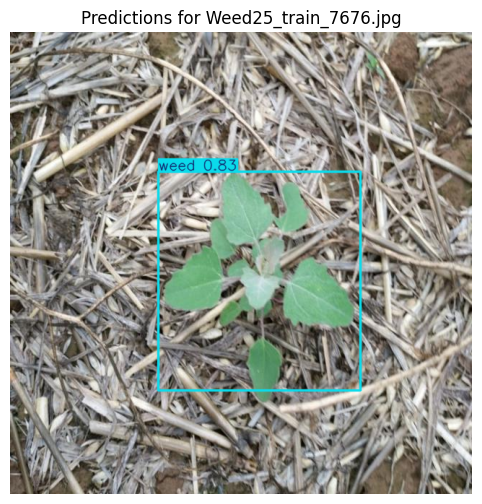


image 1/1 E:\progs\AgroVisionV2\AgroVisionDataset\images\test\Roboflow_train_14219.jpg: 640x640 2 weeds, 14.9ms
Speed: 2.9ms preprocess, 14.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


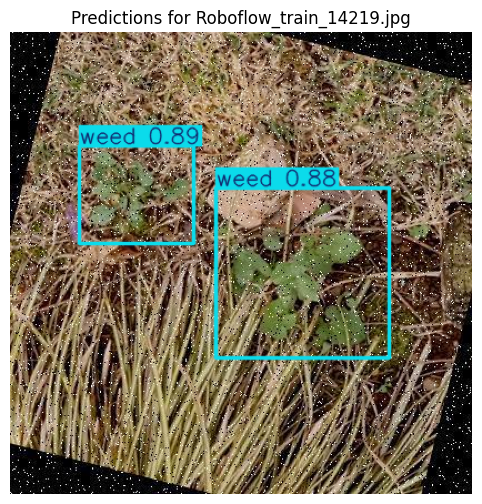


image 1/1 E:\progs\AgroVisionV2\AgroVisionDataset\images\test\Weed25_train_6034.jpg: 640x640 2 weeds, 14.7ms
Speed: 2.1ms preprocess, 14.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


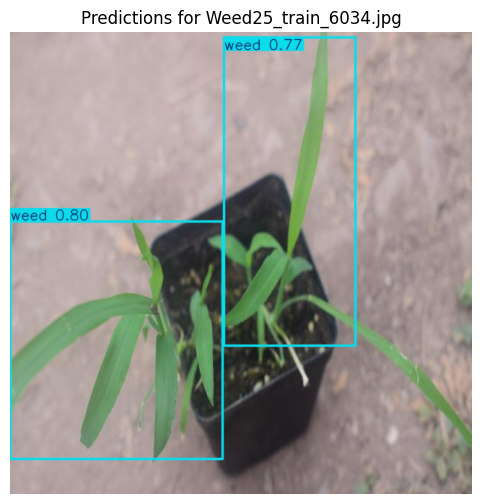


image 1/1 E:\progs\AgroVisionV2\AgroVisionDataset\images\test\Roboflow_train_12640.jpg: 640x640 14 weeds, 14.6ms
Speed: 2.8ms preprocess, 14.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


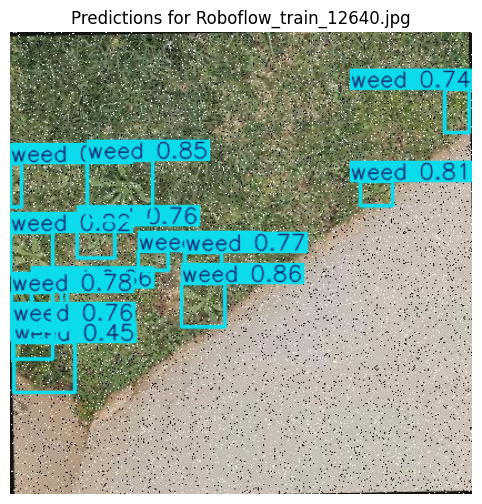


image 1/1 E:\progs\AgroVisionV2\AgroVisionDataset\images\test\Weed25_train_1360.jpg: 640x640 1 weed, 20.8ms
Speed: 2.6ms preprocess, 20.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


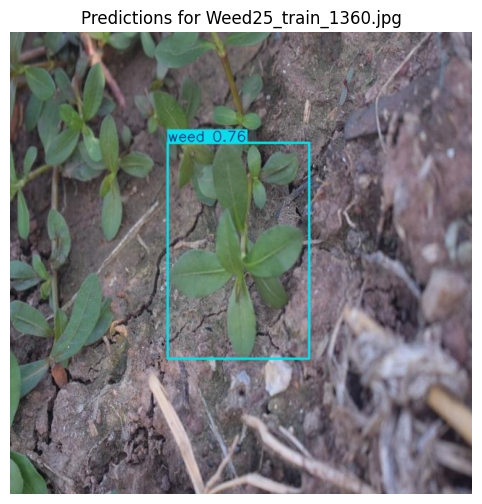

In [5]:
import os
import random
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Включаем inline отображение графиков
%matplotlib inline

# Путь к тестовым изображениям
test_dir = "AgroVisionDataset/images/test"

# Список изображений
image_extensions = (".jpg", ".jpeg", ".png")
test_images = [f for f in os.listdir(test_dir) if f.lower().endswith(image_extensions)]
selected_images = random.sample(test_images, 5) if len(test_images) >= 5 else test_images
print("Выбраны изображения:", selected_images)

# Загружаем модель
model = YOLO("runs/detect/agro_final_v11m2/weights/best.pt")

# Предсказание и вывод
for image_name in selected_images:
    img_path = os.path.join(test_dir, image_name)
    results = model(img_path)
    annotated_img = results[0].plot()
    img_rgb = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 6))
    plt.imshow(img_rgb)
    plt.title(f"Predictions for {image_name}")
    plt.axis("off")
    plt.show()


Тестирование на видео

In [2]:
import os
import cv2
from ultralytics import YOLO

# Загружаем модель
model = YOLO("runs/detect/agro_final_v11m2/weights/best.pt")

# Путь к видеофайлам
video_dir = "E:/progs/AgroVisionV2/TestVids"
input_videos = ["1.mp4", "4.mp4", "6.mp4"]

# Обработка каждого видео
for video_name in input_videos:
    input_path = os.path.join(video_dir, video_name)
    output_path = os.path.join(video_dir, f"output{video_name}")

    # Открываем видео
    cap = cv2.VideoCapture(input_path)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    # Создаём объект для записи выходного видео
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    print(f"🔄 Обработка видео: {video_name}")

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # YOLOv11: инференс + отрисовка
        results = model(frame)
        annotated_frame = results[0].plot()

        out.write(annotated_frame)

    cap.release()
    out.release()
    print(f"✅ Сохранено: {output_path}")


🔄 Обработка видео: 1.mp4

0: 640x384 1 weed, 15.2ms
Speed: 1.6ms preprocess, 15.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 weed, 14.7ms
Speed: 1.8ms preprocess, 14.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 weed, 14.6ms
Speed: 1.5ms preprocess, 14.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 weed, 17.8ms
Speed: 1.7ms preprocess, 17.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 weed, 15.1ms
Speed: 1.6ms preprocess, 15.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 weed, 14.4ms
Speed: 1.7ms preprocess, 14.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 weed, 24.3ms
Speed: 1.9ms preprocess, 24.3ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 weed, 24.2ms
Speed: 1.8ms preprocess, 24.2ms inference, 2.6ms postprocess per image at shape 

Выбраны crop-изображения для теста: ['CropWeed_1179.jpeg', 'CropWeed_1241.jpeg', 'CropWeed_891.jpeg', 'CropWeed_497.jpeg', 'CropWeed_1066.jpeg']

image 1/1 E:\progs\AgroVisionV2\AgroVisionDataset\images\test\CropWeed_1179.jpeg: 640x640 1 crop, 14.0ms
Speed: 11.5ms preprocess, 14.0ms inference, 297.3ms postprocess per image at shape (1, 3, 640, 640)


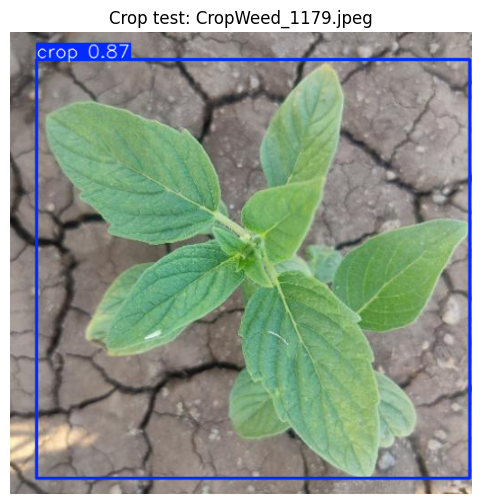


image 1/1 E:\progs\AgroVisionV2\AgroVisionDataset\images\test\CropWeed_1241.jpeg: 640x640 2 crops, 15.0ms
Speed: 3.3ms preprocess, 15.0ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)


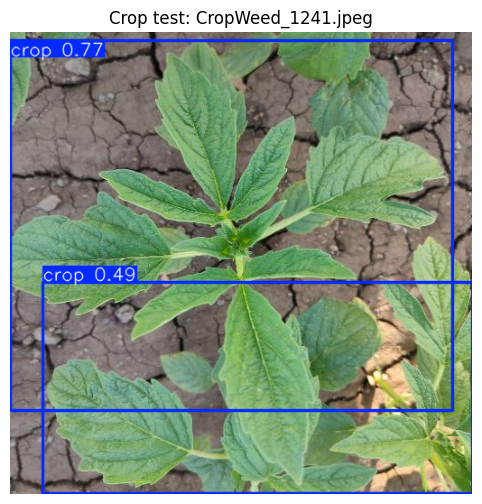


image 1/1 E:\progs\AgroVisionV2\AgroVisionDataset\images\test\CropWeed_891.jpeg: 640x640 1 crop, 24.5ms
Speed: 3.1ms preprocess, 24.5ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)


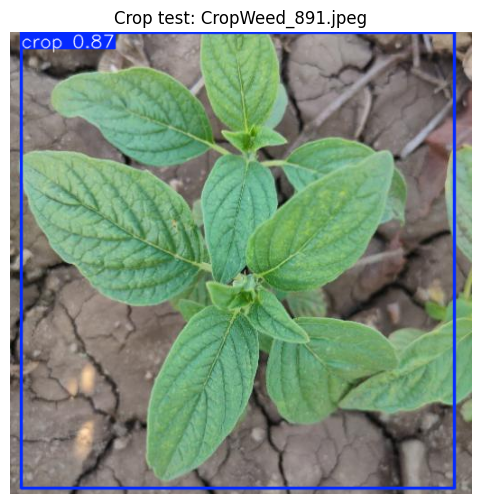


image 1/1 E:\progs\AgroVisionV2\AgroVisionDataset\images\test\CropWeed_497.jpeg: 640x640 1 crop, 13.9ms
Speed: 2.9ms preprocess, 13.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


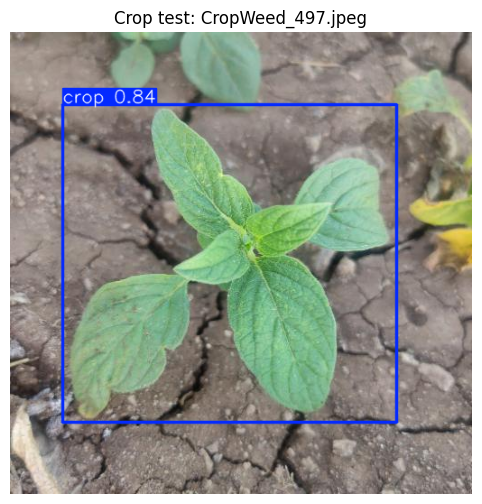


image 1/1 E:\progs\AgroVisionV2\AgroVisionDataset\images\test\CropWeed_1066.jpeg: 640x640 1 crop, 14.0ms
Speed: 3.0ms preprocess, 14.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


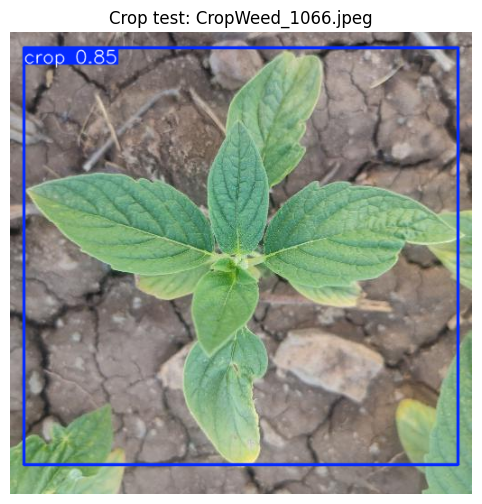

In [1]:
import os
import random
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Включаем inline отображение графиков
%matplotlib inline

# Путь к тестовым данным
test_img_dir   = "AgroVisionDataset/images/test"
test_lbl_dir   = "AgroVisionDataset/labels/test"
image_exts     = (".jpg", ".jpeg", ".png")

# 1) Собираем только те файлы, в аннотациях которых встречается класс 0 (crop)
crop_images = []
for fname in os.listdir(test_lbl_dir):
    if not fname.endswith(".txt"):
        continue
    lbl_path = os.path.join(test_lbl_dir, fname)
    with open(lbl_path, "r") as f:
        for line in f:
            cls = int(line.split()[0])
            if cls == 0:  # crop
                crop_images.append(fname.replace(".txt", ""))  # сохраняем stem
                break

# 2) Убираем дубликаты и применяем расширения
crop_images = list(set(crop_images))
crop_image_files = [
    img + ext for img in crop_images
    for ext in image_exts
    if os.path.exists(os.path.join(test_img_dir, img + ext))
]

# 3) Выбираем 5 случайных (или меньше, если их меньше)
selected = random.sample(crop_image_files, min(5, len(crop_image_files)))
print("Выбраны crop-изображения для теста:", selected)

# 4) Загружаем модель
model = YOLO("runs/detect/agro_final_v11m2/weights/best.pt")

# 5) Делаем инференс и рисуем
for image_name in selected:
    img_path = os.path.join(test_img_dir, image_name)
    results = model(img_path)
    annotated = results[0].plot()
    img_rgb = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 6))
    plt.imshow(img_rgb)
    plt.title(f"Crop test: {image_name}")
    plt.axis("off")
    plt.show()
